In this notebook, we will finetune the base phi1-5 model so it can generate test cases.

- The dataset is a synthetically generated by ChatGPT for Python programs that were a subset of the code-alpaca-20k dataset.


In [1]:
%load_ext autoreload
%autoreload 2

## Load training data


In [2]:
import json
test_cases_file = '../data/code_alpaca_with_test_cases.json'

with open(test_cases_file, encoding='utf-8') as fin:
  data = json.load(fin)

In [3]:
len(data)

4122

In [4]:
data[0]

{'instruction': 'Write a replace method for a string class which replaces the given string with a given set of characters.',
 'input': 'string = "Hello World!"\nreplace_with = "Greetings!"',
 'output': 'def replace(self, replace_with):\n    new_string = ""\n    for char in self:\n        if char == " ":\n            new_string += replace_with\n        else:\n            new_string += char\n    return new_string',
 'test_cases': 'def test_replace_with_empty_string():\n    string = "Hello World!"\n    replace_with = ""\n    assert string.replace(replace_with) == "HelloWorld!"\n\ndef test_replace_with_single_character():\n    string = "Hello World!"\n    replace_with = "A"\n    assert string.replace(replace_with) == "HelloAWorld!"\n\ndef test_replace_with_multiple_characters():\n    string = "Hello World!"\n    replace_with = "XYZ"\n    assert string.replace(replace_with) == "HelloXYZWorld!"\n\ndef test_replace_with_same_string():\n    string = "Hello World!"\n    replace_with = " "\n    

## Load models

- Download the base model and also create the model for finetuning


In [5]:
import torch
from laughing import phi15

model, peft_model, tokenizer = phi15.load_model_and_tokenizer(lora_rank=2, model_max_length=1024)

/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-10-03 23:12:38.585651: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-03 23:12:48.760230: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/intel/compilers_and_libraries_2018.3.222/linux/mpi/intel64/lib:/opt/intel/compilers_and_libraries_2018.3.222/linux/mpi/mic/lib:/o

loading model...
creating a peft model with lora (rank=2)...
trainable params: 393,216 || all params: 1,418,663,936 || trainable%: 0.027717346583764853
loading tokenizer...


In [6]:
def make_prompt(task):
    """Make the prompt for a given programming task. The prompt can be used in prediction mode."""
    # We could give the input just the instruction and output, but the prompt may help as well
    prompt = "Problem:\n"
    prompt += task['instruction'] + "\n"
    prompt += "Solution:\n"
    prompt += task['output'] + "\n\n"
    prompt += '"""Generate unit tests for the below problem and its solution in Python.\n'
    prompt += '   Write each unit test as a seperate Python function with meaningful name that starts with test_"""\n'
    return prompt

@torch.inference_mode()
def gen_test_cases(model, tokenizer, tasks, max_new_tokens:int=300):
    """Generate test cases for a batch of tasks using a model."""
    prompts = [make_prompt(task) for task in tasks]
    inputs = tokenizer(prompts, return_tensors="pt", return_attention_mask=False,
                       padding=True, truncation=True).to('cuda')
    outputs = model.generate(**inputs, max_new_tokens=max_new_tokens,
                             eos_token_id=tokenizer.eos_token_id)
    texts = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    return texts


## Test the base model's capability in generating unit tests

In [42]:
print(make_prompt(data[0]))

Problem:
Write a replace method for a string class which replaces the given string with a given set of characters.
Solution:
def replace(self, replace_with):
    new_string = ""
    for char in self:
        if char == " ":
            new_string += replace_with
        else:
            new_string += char
    return new_string

"""Generate unit tests for the below problem and its solution in Python.
   Write each unit test as a seperate Python function with meaningful name that starts with test_"""



In [43]:
texts = gen_test_cases(model, tokenizer, data[0:2])

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


In [45]:
print(texts[1])

Problem:
Write a function to find the number of distinct states in a given matrix.
Solution:
def find_num_distinct_states(matrix):      states = set()      for row in matrix:          state = "".join([str(x) for x in row])          states.add(state)      return len(states)

"""Generate unit tests for the below problem and its solution in Python.     Write each unit test as a seperate Python function with meaningful name that starts with test_"""

# Learning High School Discrete Mathematics via Python
## Section 10.1.1: What are graphs and how to represent them using Python

### Introduction
Graphs are mathematical structures that consist of vertices (or nodes) and edges (or arcs) that connect them. They are used to model various real-world scenarios, such as social networks, transportation systems, and communication networks. In this section, we will learn how to represent graphs using Python and how to perform basic operations on them.

### Representing Graphs using Python
To represen

## Fine-tune the model

In [46]:
def make_prompt_with_output(task):
  """Concatentate different parts of the input in task to make it the complete input for training."""
  prompt = make_prompt(task)
  return prompt + '\n' + task['test_cases']


In [48]:
print(make_prompt_with_output(data[0]))

Problem:
Write a replace method for a string class which replaces the given string with a given set of characters.
Solution:
def replace(self, replace_with):
    new_string = ""
    for char in self:
        if char == " ":
            new_string += replace_with
        else:
            new_string += char
    return new_string

"""Generate unit tests for the below problem and its solution in Python.
   Write each unit test as a seperate Python function with meaningful name that starts with test_"""

def test_replace_with_empty_string():
    string = "Hello World!"
    replace_with = ""
    assert string.replace(replace_with) == "HelloWorld!"

def test_replace_with_single_character():
    string = "Hello World!"
    replace_with = "A"
    assert string.replace(replace_with) == "HelloAWorld!"

def test_replace_with_multiple_characters():
    string = "Hello World!"
    replace_with = "XYZ"
    assert string.replace(replace_with) == "HelloXYZWorld!"

def test_replace_with_same_string():


In [51]:
from datasets import Dataset
import random
random.seed(1110)
random.shuffle(data)

n_train = int(0.8*len(data))
data_train = data[0:n_train]
data_test = data[n_train:]

train_dict = {
    "input": [make_prompt_with_output(item) for item in data_train if item['test_cases']],
}
test_dict = {
    "input": [make_prompt_with_output(item) for item in data_test if item['test_cases']],
}

dataset_train = Dataset.from_dict(train_dict)
dataset_train = dataset_train.map(
  lambda samples: tokenizer(samples["input"], return_tensors="pt",
                            return_attention_mask=False, truncation=True, padding=True), batched=True)
dataset_test = Dataset.from_dict(test_dict)
dataset_test = dataset_test.map(
  lambda samples: tokenizer(samples["input"], return_tensors="pt",
                            return_attention_mask=False, truncation=True, padding=True), batched=True)

Map: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 824/824 [00:02<00:00, 401.67 examples/s]


In [53]:
dataset_train, dataset_test

(Dataset({
     features: ['input', 'input_ids'],
     num_rows: 3297
 }),
 Dataset({
     features: ['input', 'input_ids'],
     num_rows: 824
 }))

In [54]:
import os
from transformers import TrainingArguments, Trainer, DataCollatorForLanguageModeling

output_directory = "../phi15_finetuned_outputs_20230928/"

if not os.path.exists(output_directory):
    os.mkdir(output_directory)

training_args = TrainingArguments(
    output_dir=output_directory,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    #auto_find_batch_size=True,
    learning_rate=5e-5, #default
    lr_scheduler_type='linear', #default
    num_train_epochs=5,
    gradient_accumulation_steps=4,
    evaluation_strategy='steps',
    eval_steps=200,
    logging_strategy='steps', #default
    logging_steps=200,
    save_strategy='steps',
    save_steps=200,
    #save_total_limit=5,
    seed=1110,
    report_to="none", # to avoid Azure ML logging issue
    #fp16=True
)

In [55]:
data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)

In [57]:
res = data_collator(dataset_train['input_ids'][0:5])

In [14]:
from laughing import utils
utils.free_gpu_memory()

Allocated GPU Memory: 7.93 GB
Maximum Allocated GPU Memory: 7.93 GB
Available GPU Memory: 7.85 GB


In [62]:
trainer = Trainer(
    model=peft_model,
    args=training_args,
    train_dataset=dataset_train,
    eval_dataset=dataset_test,
    data_collator=data_collator,
)

trainer.train()

`attention_mask` is not supported during training. Using it might lead to unexpected results.
`attention_mask` is not supported during training. Using it might lead to unexpected results.
`attention_mask` is not supported during training. Using it might lead to unexpected results.
`attention_mask` is not supported during training. Using it might lead to unexpected results.


Step,Training Loss,Validation Loss
200,0.757500,0.574963
400,0.468100,0.412767
600,0.396400,0.381845
800,0.377500,0.370786
1000,0.365100,0.364536
1200,0.364500,0.361019
1400,0.360000,0.358153
1600,0.356700,0.356554
1800,0.355300,0.355646
2000,0.355400,0.355128


`attention_mask` is not supported during training. Using it might lead to unexpected results.
`attention_mask` is not supported during training. Using it might lead to unexpected results.
`attention_mask` is not supported during training. Using it might lead to unexpected results.
`attention_mask` is not supported during training. Using it might lead to unexpected results.
`attention_mask` is not supported during training. Using it might lead to unexpected results.
`attention_mask` is not supported during training. Using it might lead to unexpected results.
`attention_mask` is not supported during training. Using it might lead to unexpected results.
`attention_mask` is not supported during training. Using it might lead to unexpected results.
`attention_mask` is not supported during training. Using it might lead to unexpected results.
`attention_mask` is not supported during training. Using it might lead to unexpected results.
`attention_mask` is not supported during training. Using it 

TrainOutput(global_step=2060, training_loss=0.4137657489591432, metrics={'train_runtime': 3727.8205, 'train_samples_per_second': 4.422, 'train_steps_per_second': 0.553, 'total_flos': 1.2496132591766323e+17, 'train_loss': 0.4137657489591432, 'epoch': 5.0})

### Training and Validation Loss Curve

In [63]:
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

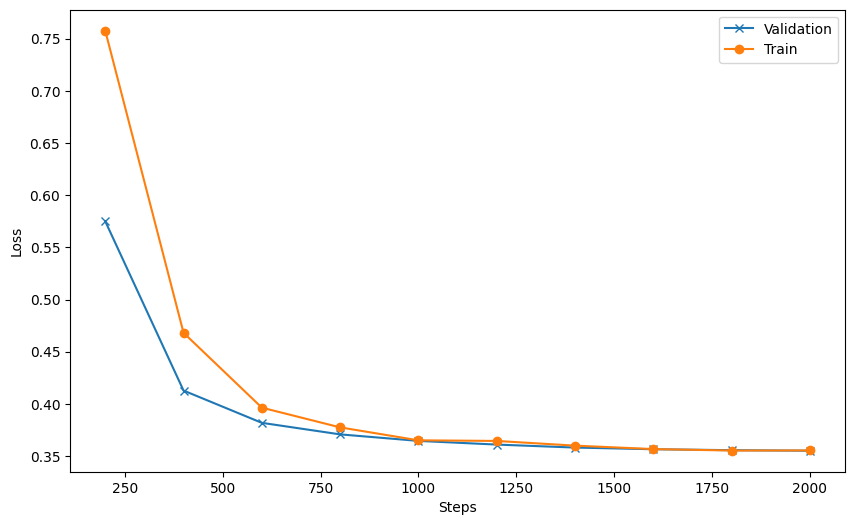

In [64]:
df = pd.DataFrame(trainer.state.log_history)
df1 = df.dropna(subset=["eval_loss"]).reset_index()[["eval_loss", "step"]]
df2 = df.dropna(subset=["loss"]).reset_index()[["loss", "step"]]

plt.figure(figsize=(10, 6))
plt.plot(df1['step'], df1['eval_loss'], label='Validation', marker='x')
plt.plot(df2['step'], df2['loss'], label='Train', marker='o')

plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.show()

## Test prediction

In [8]:
## Load the peft model
from peft import AutoPeftModelForCausalLM

peft_model = AutoPeftModelForCausalLM.from_pretrained('../phi15_finetuned_outputs_20230928/checkpoint-2000')

In [ ]:
# when generate, must set padding to left
tokenizer.padding_side = 'left'
# note: here we're using data_test and not dataset_test which doesn't contain the test cases
res = gen_test_cases(peft_model, tokenizer, data_test[0:5])

In [113]:
for response in res:
    print(response)
    print('\n========================')

Problem:
Create a function in Ruby to input an array and remove all the elements of the array
Solution:
def delete_array(arr)    arr.clear
end

"""Generate unit tests for the below problem and its solution in Python.     Write each unit test as a seperate Python function with meaningful name that starts with test_"""

def delete_array(arr):
      def delete_array(arr):
          arr.clear()
      
      def test_delete_array():
          arr = [1, 2, 3, 4, 5]
          delete_array(arr)
          assert arr == []

def test_delete_array_empty_array():
      arr = []
      delete_array(arr)
      assert arr == []

def test_delete_array_with_duplicates():
      arr = [1, 2, 3, 4, 5, 5, 5]
      delete_array(arr)
      assert arr == []

def test_delete_array_with_duplicates_with_empty_array():
      arr = [1, 2, 3, 4, 5, 5]
      delete_array(arr)
      assert arr == []

def test_delete_array_with_duplicates_with_non_empty_array():
      arr = [1, 2, 3, 4, 5, 5]
      delete_array(arr)
   

## Test prediction on the code/program generated by the base Phi model

In [10]:
import json

with open('../data/code_alpaca_v2.json', encoding='utf-8') as fin:
    alpaca_data = json.load(fin)

# hack: replace the original output with phi_base_output -> this will generate test cases for the 
# program generated by the base model, not the groundtruth program
new_tasks = [{'instruction': t['instruction'], 'output': t['phi_base_output']} for t in alpaca_data]

In [15]:
res  = gen_test_cases(peft_model, tokenizer, new_tasks[0:5])

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [16]:
for x in res:
    print(x)
    print("\n========================================")

Problem:
Fix the following function to make it comply with PEP8 standards.
Solution:
def fibonacci(n):        if n <= 1:            return n        else:            return fibonacci(n-1) + fibonacci(n-2)

"""Generate unit tests for the below problem and its solution in Python.     Write each unit test as a seperate Python function with meaningful name that starts with test_"""

def test_fibonacci():
      def test_fibonacci(n):
          assert fibonacci(n) == fibonacci(n-1) + fibonacci(n-2)

def test_fibonacci_positive():
      assert fibonacci(0) == 0
      assert fibonacci(1) == 1
      assert fibonacci(2) == 1
      assert fibonacci(3) == 1
      assert fibonacci(4) == 1
      assert fibonacci(5) == 2
      assert fibonacci(6) == 3
      assert fibonacci(7) == 5
      assert fibonacci(8) == 3
      assert fibonacci(9) == 8
      assert fibonacci(10) == 13
      assert fibonacci(11) == 13
      assert fibonacci(12) == 21
      assert fibonacci(13) == 34
      assert fibonacci(14) ==